# Image Processing CookBook
## Chapter 7
### Author - Sandipan Dey

### Human pose estimation using Deep Learning

In [47]:
%matplotlib inline
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

proto_file = "models/pose_deploy_linevec_faster_4_stages.prototxt"
weights_file = "models/pose_iter_160000.caffemodel"
n_points = 15
BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4, 
              "LShoulder": 5,  "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
             "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14, "Background": 15}

#POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
             ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
             ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
             ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]


image = cv2.imread("images/leander.jpg")
height, width = image.shape[:2]
threshold = 0.1

net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)
blob = cv2.dnn.blobFromImage(image, 1.0 / 255, (368,368), (0, 0, 0), swapRB=False, crop=False)
net.setInput(blob)
output = net.forward()
h, w = output.shape[2:4]
print(output.shape)

(1, 44, 46, 46)


(-0.5, 425.5, 347.5, -0.5)

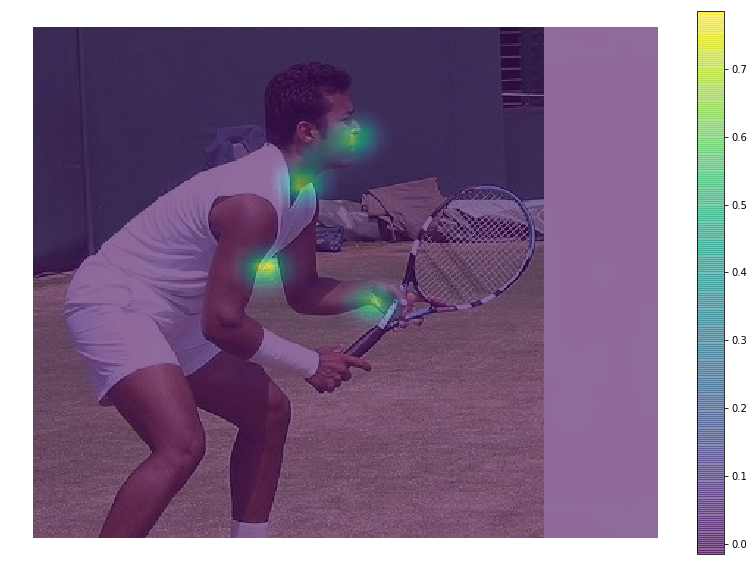

In [48]:
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
prob_map = np.zeros((width, height))
for i in range(1,5):
    pmap = output[0, i, :, :]
    prob_map += cv2.resize(pmap, (height, width))
plt.imshow(prob_map, alpha=0.6)
plt.colorbar()
plt.axis("off")

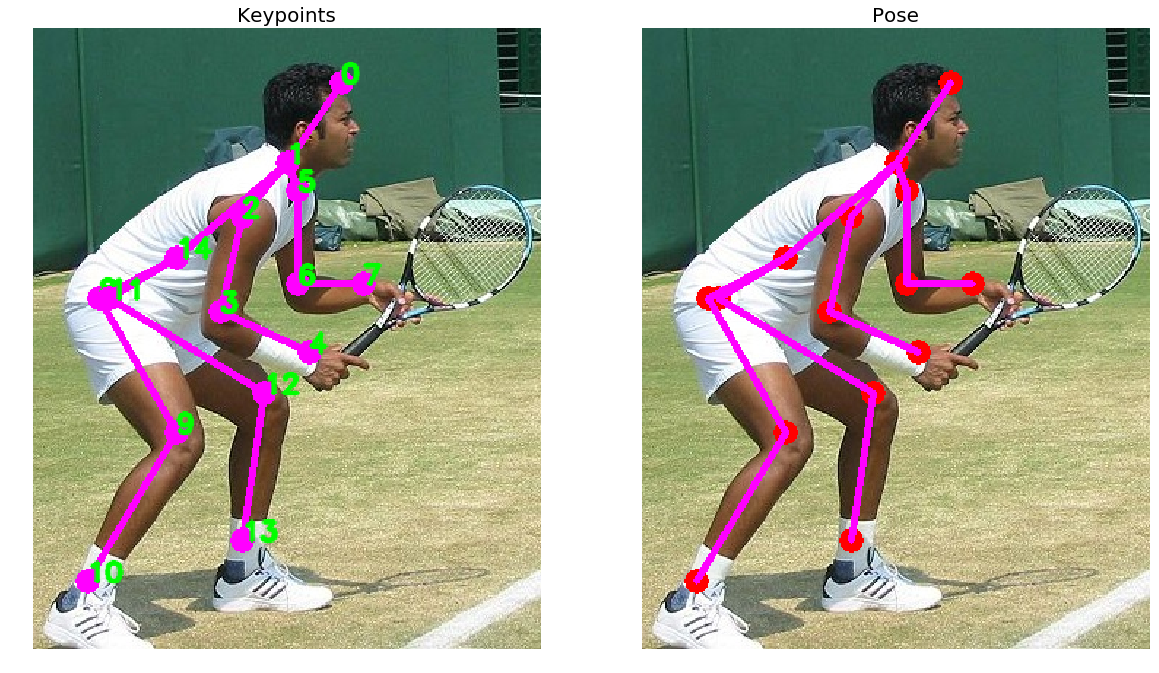

In [50]:
image1 = image.copy()

# Empty list to store the detected keypoints
points = []

for i in range(n_points):
    # confidence map of corresponding body's part.
    prob_map = output[0, i, :, :]

    # Find local maxima of the prob_map.
    min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)
    
    # Scale the point to fit on the original image
    x = (width * point[0]) / w
    y = (height * point[1]) / h

    if prob > threshold : 
        cv2.circle(image1, (int(x), int(y)), 8, (255, 0, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(image1, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, lineType=cv2.LINE_AA)
        cv2.circle(image, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    part_from = BODY_PARTS[pair[0]]
    part_to = BODY_PARTS[pair[1]]

    if points[part_from] and points[part_to]:
        cv2.line(image, points[part_from], points[part_to], (255, 0, 255), 3)

plt.figure(figsize=[20,12])
plt.subplot(121), plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Keypoints', size=20)
plt.subplot(122), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Pose', size=20)
plt.show()